# Leios simulation analysis for CIP

## Set up

### Load packages

In [1]:
suppressMessages({
    require(RColorBrewer, quietly=TRUE)
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

## Experiment: Regression across `sim-cli` versions

### Analysis of lifecycles and efficiencies

#### Read the lifecycle results

In [2]:
if (file.exists("results/lifecycle.Rdata")) {
    load(file="results/lifecycle.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    lifecycle <- fread("results/lifecycle.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
    save(lifecycle, sampleSize, file="results/lifecycle.R")
    cat(paste("Saved Rdata file: sampleSize =", sampleSize, "\n"))
}
setnames(lifecycle, old="Kind", new="Message")
lifecycle %>% summary

Loaded Rdata file: sampleSize = 1 


  sim-cli       Tx start [s]  Tx stop [s]   Sim stop [s]  Message    
 0.1.0:60105   Min.   :60    Min.   :660   Min.   :1200   EB:   255  
 1.0.0:60105   1st Qu.:60    1st Qu.:660   1st Qu.:1200   RB:   270  
 1.1.0:60105   Median :60    Median :660   Median :1200   TX:300005  
 1.2.0:60105   Mean   :60    Mean   :660   Mean   :1200              
 1.3.0:60110   3rd Qu.:60    3rd Qu.:660   3rd Qu.:1200              
               Max.   :60    Max.   :660   Max.   :1200              
                                                                     
            Item           Size [B]        References      Created [s]     
 1083-node-568:     9   Min.   :   240   Min.   : 0.000   Min.   :  20.07  
 20-node-220  :     9   1st Qu.:  1500   1st Qu.: 2.000   1st Qu.: 210.14  
 1051-node-135:     8   Median :  1500   Median : 2.000   Median : 360.22  
 1058-node-94 :     8   Mean   :  1640   Mean   : 2.932   Mean   : 360.36  
 1062-node-529:     8   3rd Qu.:  1500   3rd Qu.: 3.000   3r

#### Range of transaction injection

In [3]:
txFirst <- lifecycle[, median(`Tx start [s]`)]
txLast <- lifecycle[, median(`Tx stop [s]`)]
txWindow <- txLast - txFirst
simFinish <- lifecycle[, median(`Sim stop [s]`)]

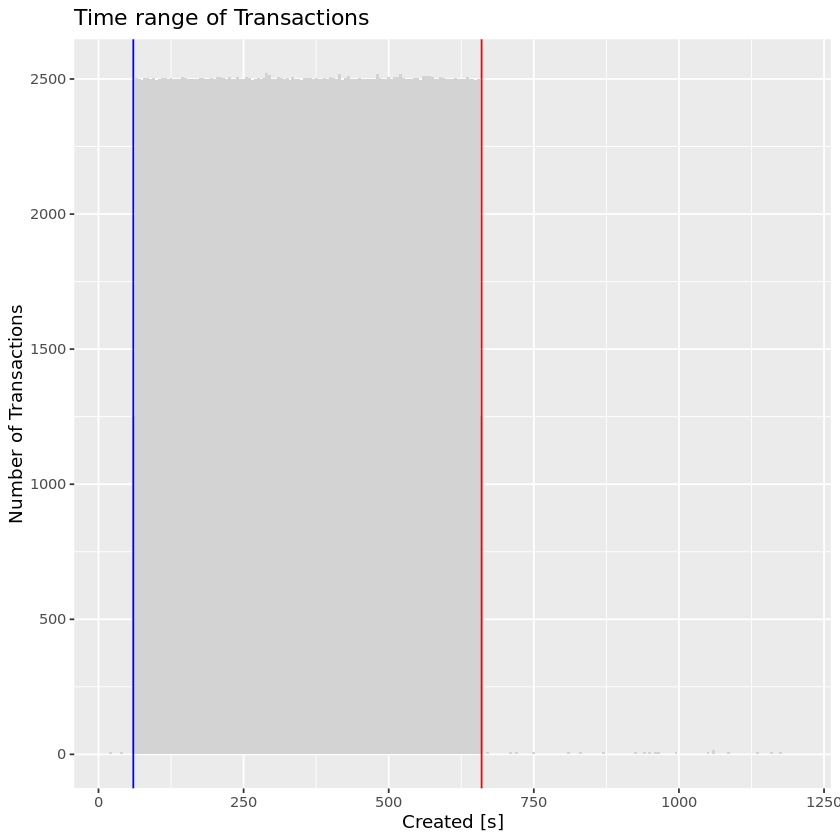

In [4]:
ggplot(lifecycle, aes(x=`Created [s]`)) +
    geom_histogram(binwidth=5, fill="lightgray") +
    geom_vline(xintercept=txFirst, color="blue") +
    geom_vline(xintercept=txLast, color="red") +
    ylab("Number of Transactions") +
    ggtitle("Time range of Transactions")

#### Actual TPS

In [5]:
lifecycle[
    `Message` == "TX" & `Created [s]` >= txFirst & `Created [s]` <= txLast, 
    .(
        `Demand [tx/s]`=.N/txWindow
    ),
    .(`sim-cli`)
]

sim-cli,Demand [tx/s]
<fct>,<dbl>
1.0.0,100.0017
1.3.0,100.0000
0.1.0,100.0000
1.1.0,100.0017
1.2.0,100.0017


#### Size of persisted data

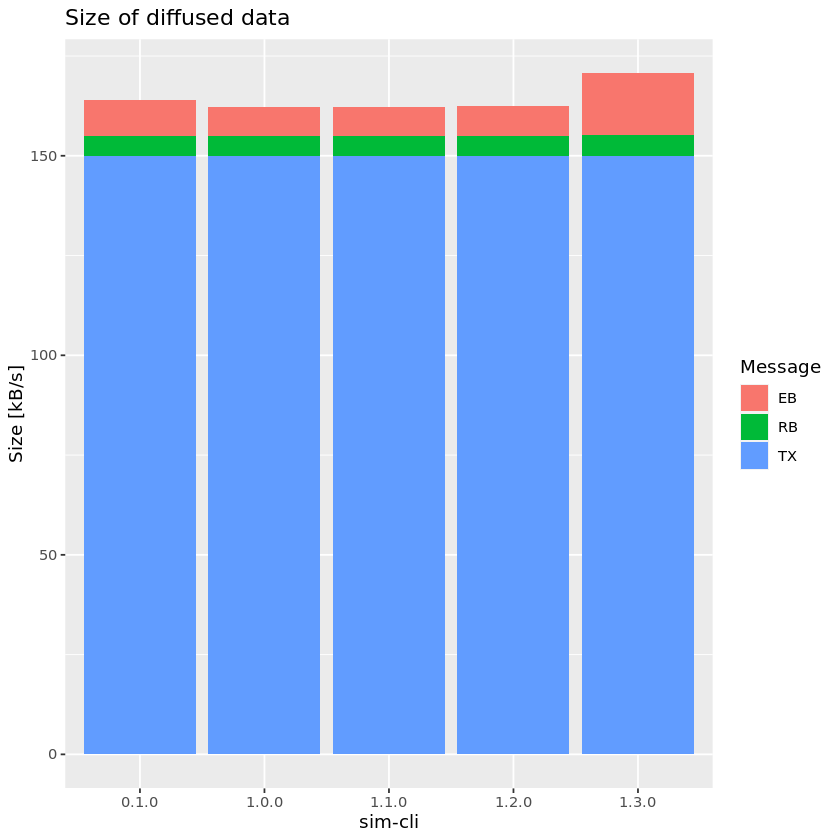

In [6]:
ggplot(
    lifecycle[
        ,
        .(`Size [kB/s]`=sum(`Size [B]`)/1e3/600),
        .(`sim-cli`, `Message`)
    ],
    aes(x=`sim-cli`, y=`Size [kB/s]`, fill=`Message`)
) + geom_bar(stat="identity") +
    ggtitle("Size of diffused data")

#### Spatial efficiency

In [7]:
lifecycle[
        `Message` == "TX", 
        .(`Tx size [B]`=sum(ifelse(is.na(`To RB [s]`) & is.na(`In RB [s]`), 0, 1.0 * `Size [B]`))),
        .(`sim-cli`)
    ][
        lifecycle[
            , 
            .(`Non-tx size [B]`=sum(as.numeric((`Message` == "TX" | `Message` == "EB" | `Message` == "RB") * `Size [B]`))), 
            .(`sim-cli`)
        ],
        on="sim-cli"
    ][, .(`Space efficiency [%]`=100*`Tx size [B]`/`Non-tx size [B]`), .(`sim-cli`)]

sim-cli,Space efficiency [%]
<fct>,<dbl>
1.0.0,92.46753
1.3.0,87.89282
0.1.0,91.53546
1.1.0,92.46869
1.2.0,92.38376


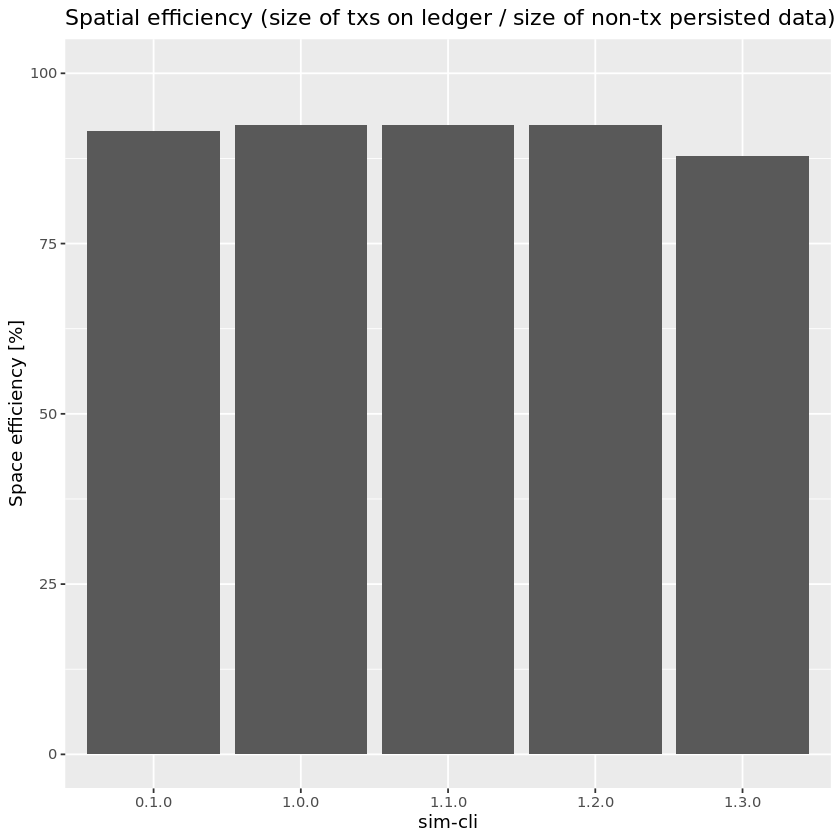

In [8]:
ggplot(
    lifecycle[
        `Message` == "TX", 
        .(`Tx size [B]`=sum(ifelse(is.na(`To RB [s]`) & is.na(`In RB [s]`), 0, 1.0 * `Size [B]`))),
        .(`sim-cli`)
    ][
        lifecycle[
            `Message` != "VT", 
            .(`Non-tx size [B]`=sum(as.numeric((`Message` == "TX" | `Message` == "EB" | `Message` == "RB") * `Size [B]`))), 
            .(`sim-cli`)
        ],
        on="sim-cli"
    ][, .(`Space efficiency [%]`=100*`Tx size [B]`/`Non-tx size [B]`), .(`sim-cli`)],
    aes(x=`sim-cli`, y=`Space efficiency [%]`)
) +
    geom_bar(stat="identity") +
    ylim(0, 100) +
    ggtitle("Spatial efficiency (size of txs on ledger / size of non-tx persisted data)")

#### Time to reach the EB

In [9]:
lifecycle[
        !is.na(`To EB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach EB [s]`=mean(`To EB [s]`-`Created [s]`)), 
        .(`sim-cli`)
    ]

sim-cli,Time to reach EB [s]
<fct>,<dbl>
1.0.0,21.17686
1.3.0,42.47322
0.1.0,21.15817
1.1.0,21.35634
1.2.0,21.35162


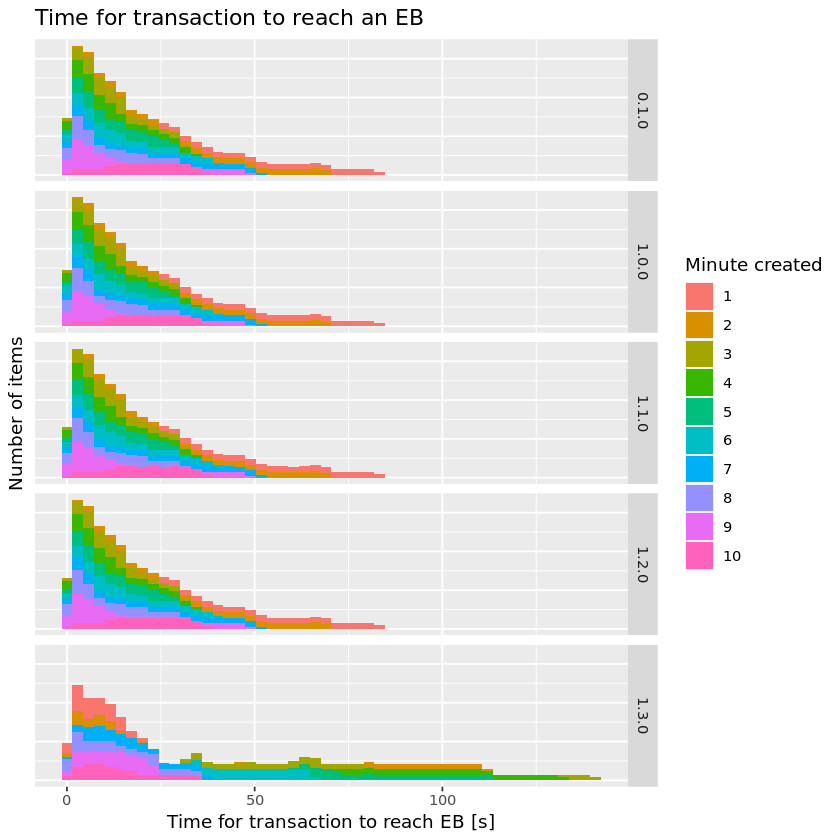

In [10]:
ggplot(
        lifecycle[
            `Message` == "TX" & 
            !is.na(`To EB [s]`) &
            `Created [s]` >= txFirst & `Created [s]` < txLast, 
            .(`Time to reach EB [s]`=(`To EB [s]`-`Created [s]`)), 
            .(`sim-cli`, `Minute created`=factor(floor(`Created [s]`/60)))
        ],
    aes(x=`Time to reach EB [s]`, fill=`Minute created`)
) + geom_histogram(bins=50, position="stack") +
    facet_grid(`sim-cli` ~ .) +
    xlab("Time for transaction to reach EB [s]") +
    ylab("Number of items") +
    ggtitle("Time for transaction to reach an EB") +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [11]:
ggsave("plots/tx-reaches-eb.png", units="in", dpi=150, width=8, height=6)

#### Time to reach the ledger

In [12]:
lifecycle[
        !is.na(`To RB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach ledger [s]`=mean(`To RB [s]`-`Created [s]`)), 
        .(`sim-cli`)
    ]

sim-cli,Time to reach ledger [s]
<fct>,<dbl>
1.0.0,48.98609
1.3.0,88.40101
0.1.0,55.78455
1.1.0,49.16126
1.2.0,48.39886


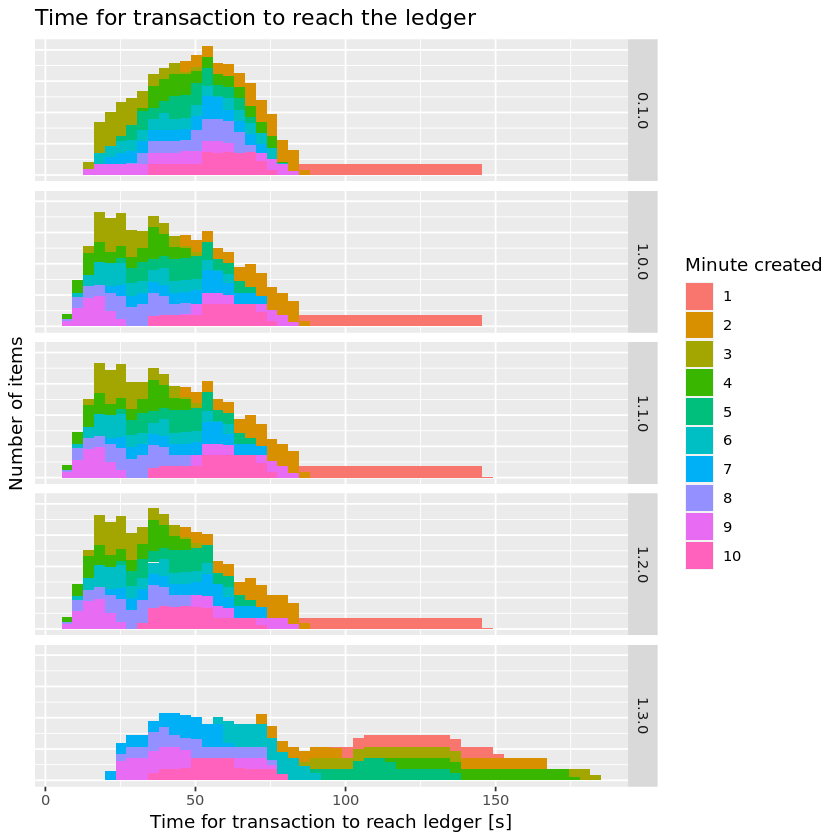

In [13]:
ggplot(
        lifecycle[
            `Message` == "TX" & 
            !is.na(`To RB [s]`) &
            `Created [s]` >= txFirst & `Created [s]` < txLast, 
            .(`Time to reach ledger [s]`=`To RB [s]`-`Created [s]`), 
            .(`sim-cli`, `Minute created`=factor(floor(`Created [s]`/60)))
        ],
    aes(x=`Time to reach ledger [s]`, fill=`Minute created`)
) + geom_histogram(bins=50) +
    facet_grid(`sim-cli` ~ .) +
    xlab("Time for transaction to reach ledger [s]") +
    ylab("Number of items") +
    ggtitle("Time for transaction to reach the ledger") +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [14]:
ggsave("plots/tx-reaches-rb.png", units="in", dpi=150, width=8, height=6)

#### Number of references

A *reference* is one of the following:

- A transaction is included in an IB.
- An IB is referenced by an EB.
- An EB is referenced by another EB.

In an efficient Leios, the number of references for each data item would be one.

- *Zero references* indicates that the item was not used.
- *Two or more references* indicates that duplication has occurred.

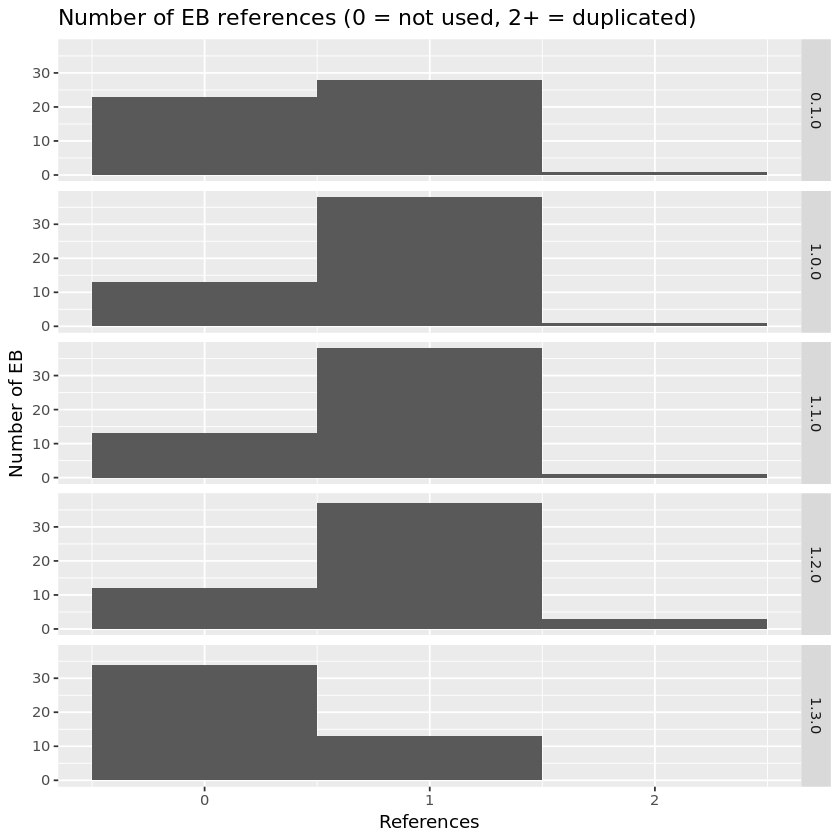

In [15]:
ggplot(
    lifecycle[
        `Message` == "EB",
        .(`References`),
        .(`sim-cli`)
    ], 
    aes(x=`References`)
) +
    geom_histogram(binwidth=1) +
    facet_grid(`sim-cli` ~ .) +
    ylab("Number of EB") +
    ggtitle("Number of EB references (0 = not used, 2+ = duplicated)")

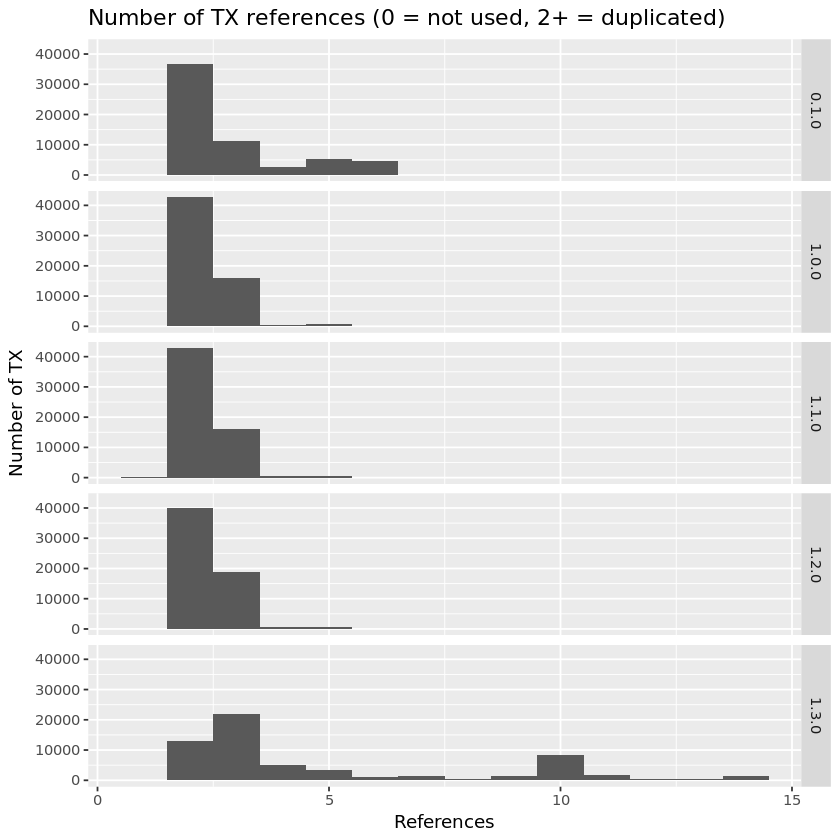

In [16]:
ggplot(
    lifecycle[
        `Message` == "TX",
        .(`References`),
        .(`sim-cli`)
    ], 
    aes(x=`References`)
) +
    geom_histogram(binwidth=1) +
    facet_grid(`sim-cli` ~ .) +
    ylab("Number of TX") +
    ggtitle("Number of TX references (0 = not used, 2+ = duplicated)")

In [17]:
ggsave("plots/tx-references.png", units="in", dpi=150, width=8, height=6)

#### Temporal efficiency

In [18]:
toElapsed <- function(created, toRb, inRb) {
    if (!is.na(toRb))
        toRb - created
    else if (!is.na(inRb))
        inRb - created
    else
        as.numeric(NA)
}

In [19]:
outcomes <- lifecycle[
    `Created [s]` < txLast,
    .(
        `Submitted [minute]`=factor(floor(`Created [s]`/60)), 
        `Time to reach ledger [s]`=mapply(toElapsed, `Created [s]`, `To RB [s]`, `In RB [s]`)
    ),
    .(`sim-cli`)
]

In [20]:
totals <- 
    outcomes[
        , 
        .(
            `Total`=.N, 
            `Lost`=sum(is.na(`Time to reach ledger [s]`)),
            `1st min`=sum(`Time to reach ledger [s]`<=60,na.rm=TRUE),
            `2nd min`=sum(`Time to reach ledger [s]`>60&`Time to reach ledger [s]`<=120,na.rm=TRUE),
            `3rd min`=sum(`Time to reach ledger [s]`>120&`Time to reach ledger [s]`<=180,na.rm=TRUE)
        ), 
        .(`sim-cli`, `Submitted [minute]`)
    ]

#### Transactions reaching the ledger

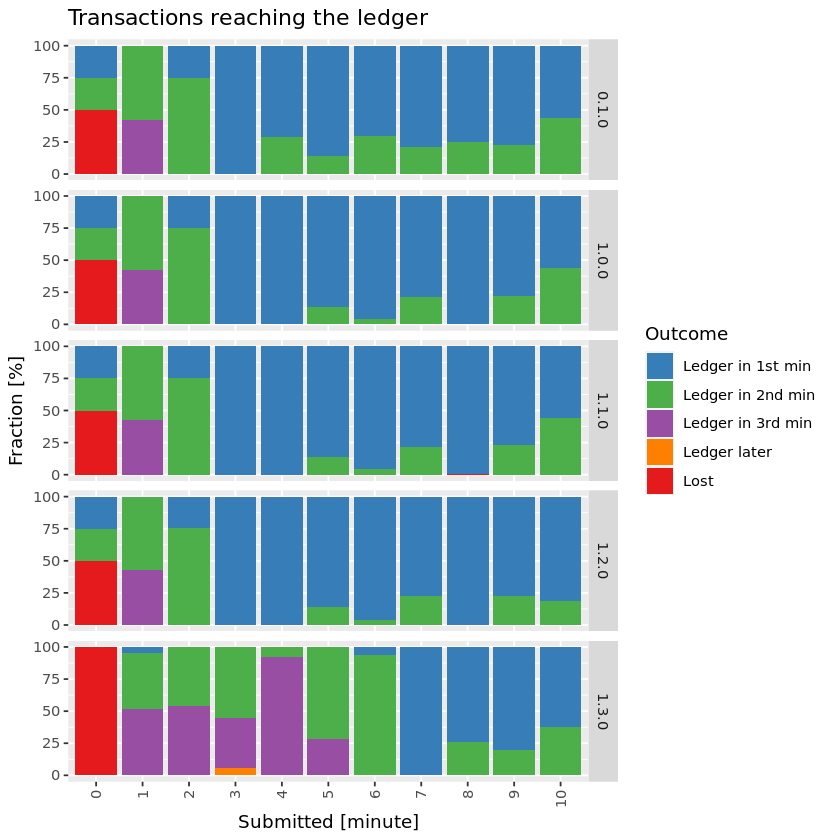

In [21]:
ggplot(
        melt(
            totals[
                , 
                .(
                    `Ledger in 1st min`=`1st min`/`Total`, 
                    `Ledger in 2nd min`=`2nd min`/`Total`, 
                    `Ledger in 3rd min`=`3rd min`/`Total`, 
                    `Ledger later`=(`Total`-`Lost`-`1st min`-`2nd min`-`3rd min`)/`Total`,
                    `Lost`=`Lost`/`Total`
                ), 
                .(`sim-cli`, `Submitted [minute]`)
            ],
            id.vars=c("sim-cli", "Submitted [minute]"),
            variable.name="Outcome",
            value.name="Fraction"
        )[, .(
            `sim-cli`,
            `Submitted [minute]`, 
            `Outcome`=factor(`Outcome`,levels=c("Ledger in 1st min", "Ledger in 2nd min", "Ledger in 3rd min", "Ledger later","Lost")), 
            `Fraction [%]`=100*`Fraction`
        )],
    aes(x=`Submitted [minute]`, y=`Fraction [%]`, fill=`Outcome`)
) +
    geom_bar(stat="identity") +
    facet_grid(`sim-cli` ~ .) +
    scale_fill_manual(values=c(
        "Ledger in 1st min"=brewer.pal(n=5, name="Set1")[[2]], 
        "Ledger in 2nd min"=brewer.pal(n=5, name="Set1")[[3]], 
        "Ledger in 3rd min"=brewer.pal(n=5, name="Set1")[[4]], 
        "Ledger later"=brewer.pal(n=5, name="Set1")[[5]],
        "Lost"=brewer.pal(n=5, name="Set1")[[1]]
    )) +
    ggtitle("Transactions reaching the ledger") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

### Resource usage

In [22]:
if (file.exists("results/resources.Rdata")) {
    load(file="results/resources.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    resources <- fread("results/resources.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
    save(resources, file="results/resources.Rdata")
    cat(paste("Saved Rdata file: sampleSize =", sampleSize, "\n"))
}
resources %>% summary

Loaded Rdata file: sampleSize = 1 


  sim-cli     Tx start [s]  Tx stop [s]   Sim stop [s]        Node     
 0.1.0:750   Min.   :60    Min.   :660   Min.   :1200   node-0  :   5  
 1.0.0:750   1st Qu.:60    1st Qu.:660   1st Qu.:1200   node-1  :   5  
 1.1.0:750   Median :60    Median :660   Median :1200   node-10 :   5  
 1.2.0:750   Mean   :60    Mean   :660   Mean   :1200   node-100:   5  
 1.3.0:750   3rd Qu.:60    3rd Qu.:660   3rd Qu.:1200   node-101:   5  
             Max.   :60    Max.   :660   Max.   :1200   node-102:   5  
                                                        (Other) :3720  
   Egress [B]           Disk [B]      Total CPU [s]   Maximum CPU [s/s]
 Min.   :     7544   Min.   :     0   Min.   :66.11   Min.   :0.4187   
 1st Qu.:  6267357   1st Qu.:     0   1st Qu.:66.41   1st Qu.:0.6466   
 Median : 63503654   Median :     0   Median :66.45   Median :0.6504   
 Mean   : 94275314   Mean   : 11414   Mean   :67.97   Mean   :0.6756   
 3rd Qu.:128328399   3rd Qu.:     0   3rd Qu.:67.46   3rd Qu.:0.

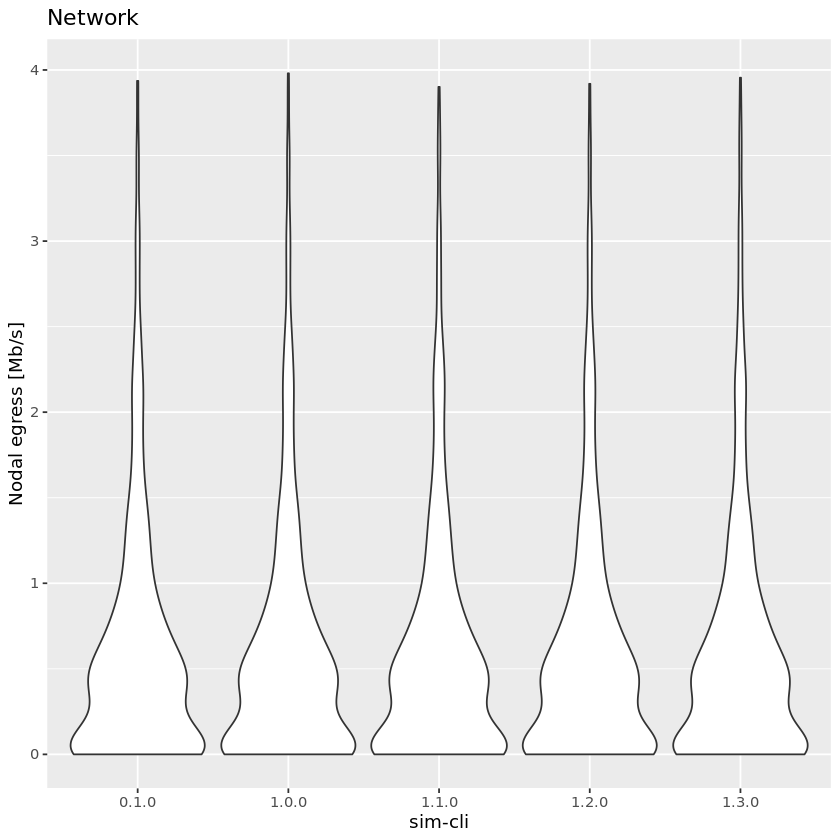

In [23]:
ggplot(
        resources[, .(`sim-cli`, `Node`, `Nodal egress [Mb/s]`=8*`Egress [B]`/simFinish/1e6)], 
    aes(x=`sim-cli`, y=`Nodal egress [Mb/s]`)
) +
    geom_violin() +
    ggtitle("Network")

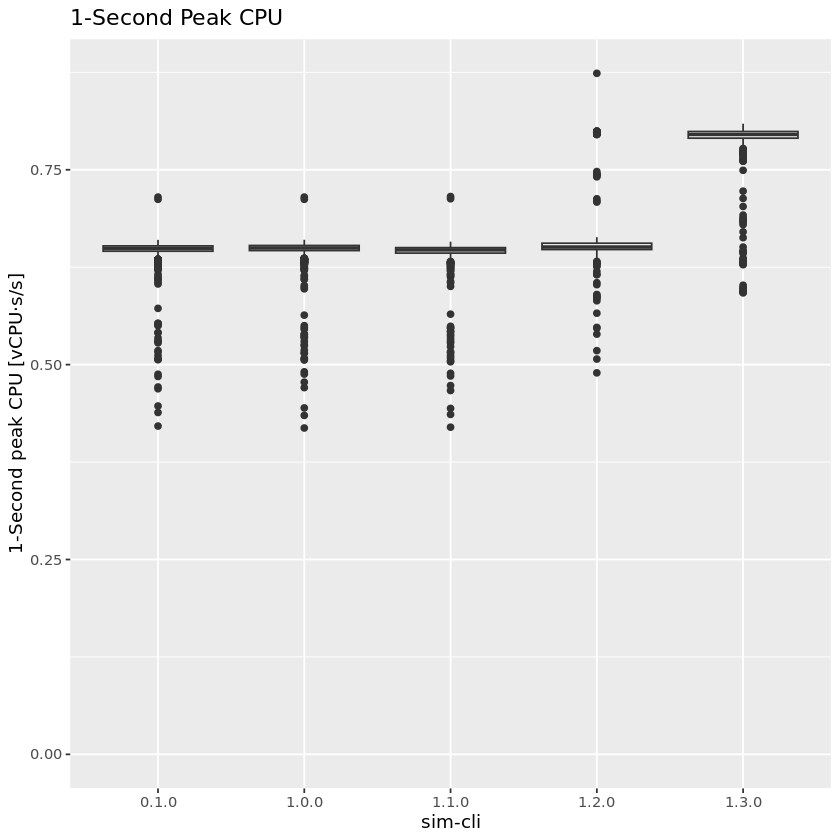

In [24]:
ggplot(
        resources[, .(`sim-cli`, `Node`, `1-Second peak CPU [vCPU⋅s/s]`=`Maximum CPU [s/s]`)], 
    aes(x=`sim-cli`, y=`1-Second peak CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    ggtitle("1-Second Peak CPU")

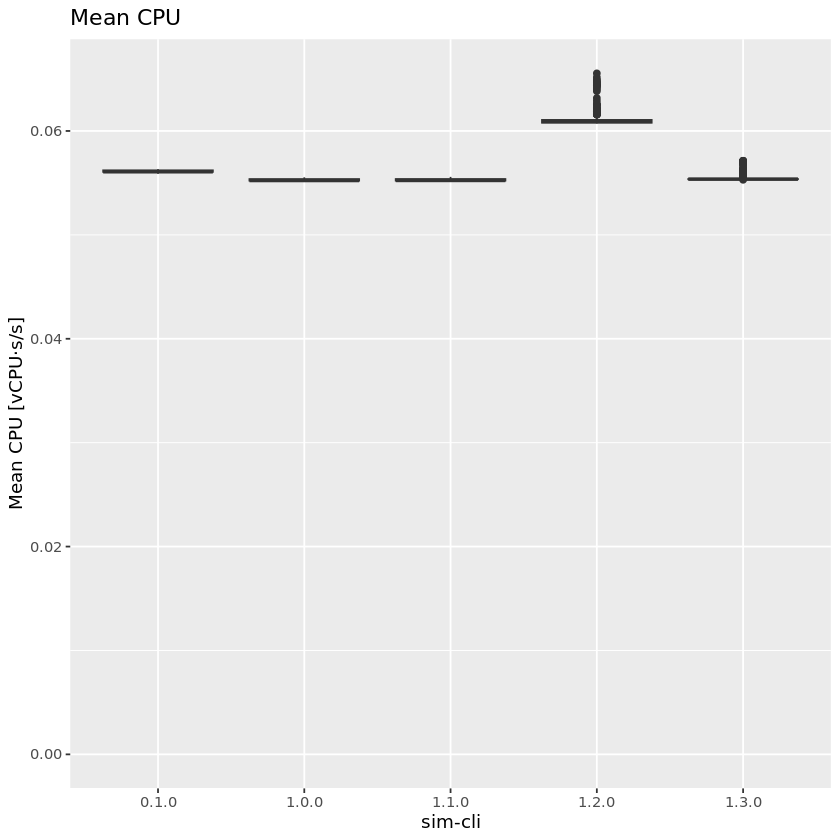

In [25]:
ggplot(
        resources[, .(`sim-cli`, `Node`, `Mean CPU [vCPU⋅s/s]`=`Total CPU [s]`/simFinish)], 
    aes(x=`sim-cli`, y=`Mean CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    ggtitle("Mean CPU")

### Receipt of messages

#### Read results

In [26]:
if (file.exists("results/receipts.Rdata")) {
    load("results/receipts.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    receipts <- fread("results/receipts.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
    save(receipts, file="results/receipts.Rdata")
    cat(paste("Saved Rdata file: sampleSize =", sampleSize, "\n"))
}
setnames(receipts, old="Kind", new="Message")
receipts %>% summary

Loaded Rdata file: sampleSize = 0.5 


  sim-cli          Tx start [s]  Tx stop [s]   Sim stop [s]  Message       
 0.1.0:25695205   Min.   :60    Min.   :660   Min.   :1200   EB:    94395  
 1.0.0:25696390   1st Qu.:60    1st Qu.:660   1st Qu.:1200   RB:   117641  
 1.1.0:25697168   Median :60    Median :660   Median :1200   TX:112354480  
 1.2.0:25691895   Mean   :60    Mean   :660   Mean   :1200   VT: 14996903  
 1.3.0:24782761   3rd Qu.:60    3rd Qu.:660   3rd Qu.:1200                 
                  Max.   :60    Max.   :660   Max.   :1200                 
                                                                           
            Item               Producer         Generated [s]    
 1083-node-568:     5609   node-447:   258275   Min.   :  20.07  
 1062-node-529:     5527   node-33 :   257824   1st Qu.: 220.23  
 1133-node-94 :     5308   node-517:   253373   Median : 375.46  
 926-node-182 :     5252   node-122:   248077   Mean   : 387.31  
 811-node-217 :     5241   node-360:   245151   3rd Qu.: 531.9

In [27]:
kinds <- receipts[, unique(`Message`) %>% sort]
kinds

[1] EB RB TX VT
Levels: EB RB TX VT

#### Arrival histograms

##### Compare the distributions of elapsed times

In [28]:
arrivalDelayHistogram <- function(rs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
            rs[, .(`sim-cli`, `Elapsed [s]`, `Minute created`=factor(floor(`Generated [s]`/60)))],
        aes(x=`Elapsed [s]`, fill=`Minute created`)
    ) +
        geom_histogram(binwidth=0.1) +
        facet_grid(`sim-cli` ~ ., scales=scales) +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle(title) +
        theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

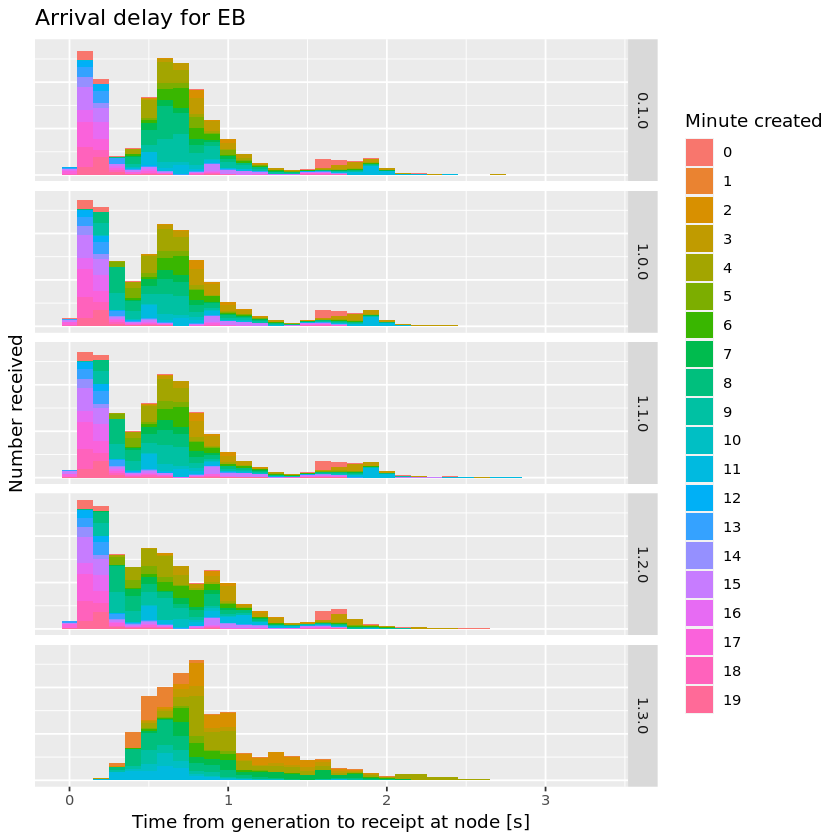

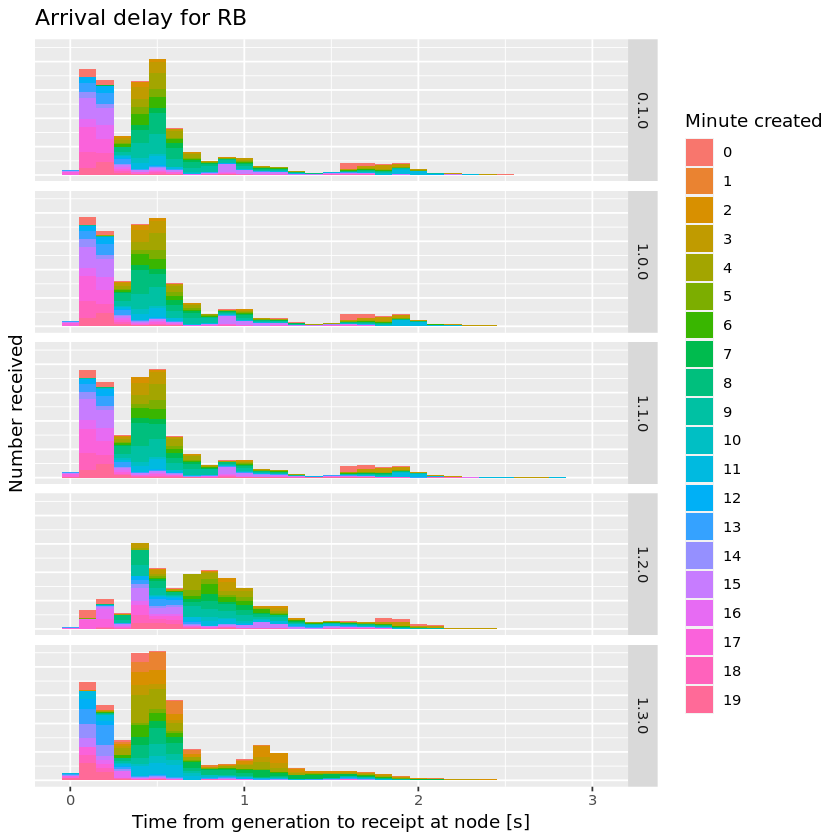

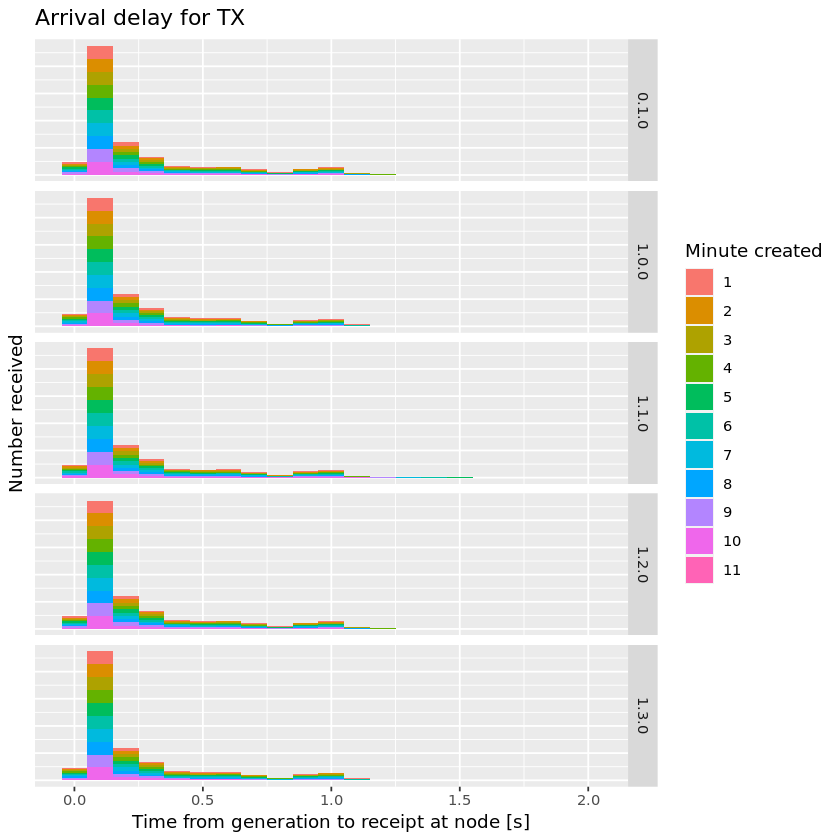

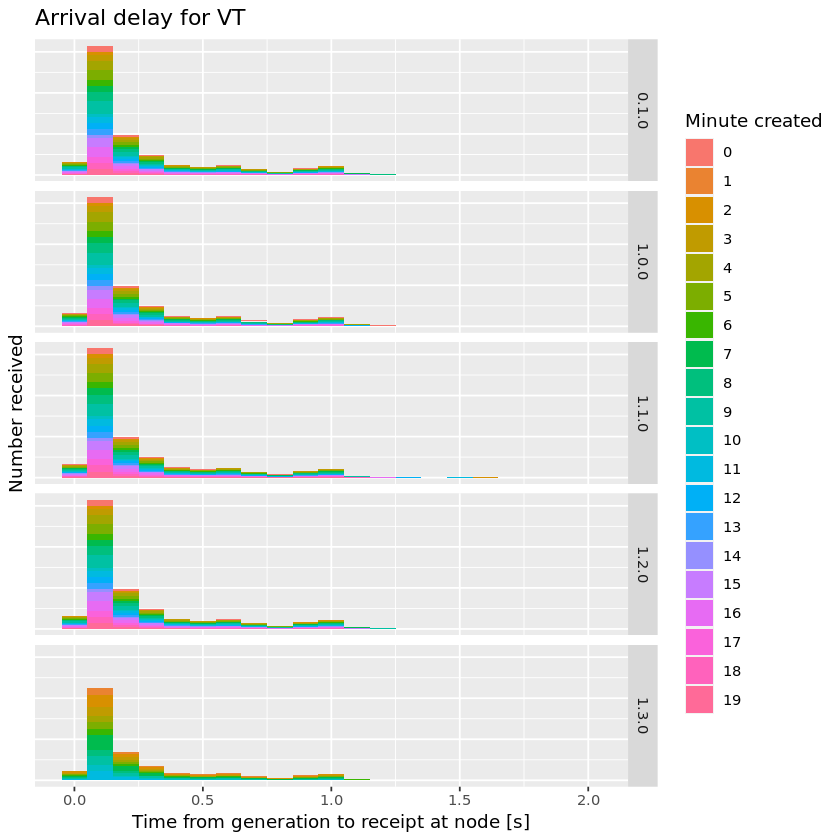

In [29]:
for (k in kinds)
    arrivalDelayHistogram(
        receipts[`Message` == k],
        paste("Arrival delay for", k),
        scales="fixed"
    ) %>% print

#### Bandwidth usage

##### Total network bandwidth

In [30]:
totalBandwidthPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
            rs[,
                .(`Size [Gb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e9/sampleSize),
                by=.(`sim-cli`, `Slot`=floor(`Received [s]`), `Message`)
            ],
        aes(x=`Slot`, y=`Size [Gb]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`sim-cli` ~ ., scales=scales) +
        xlab("Slot [s]") +
        ylab("Total network ingress [Gb/s]") +
        ggtitle(title)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

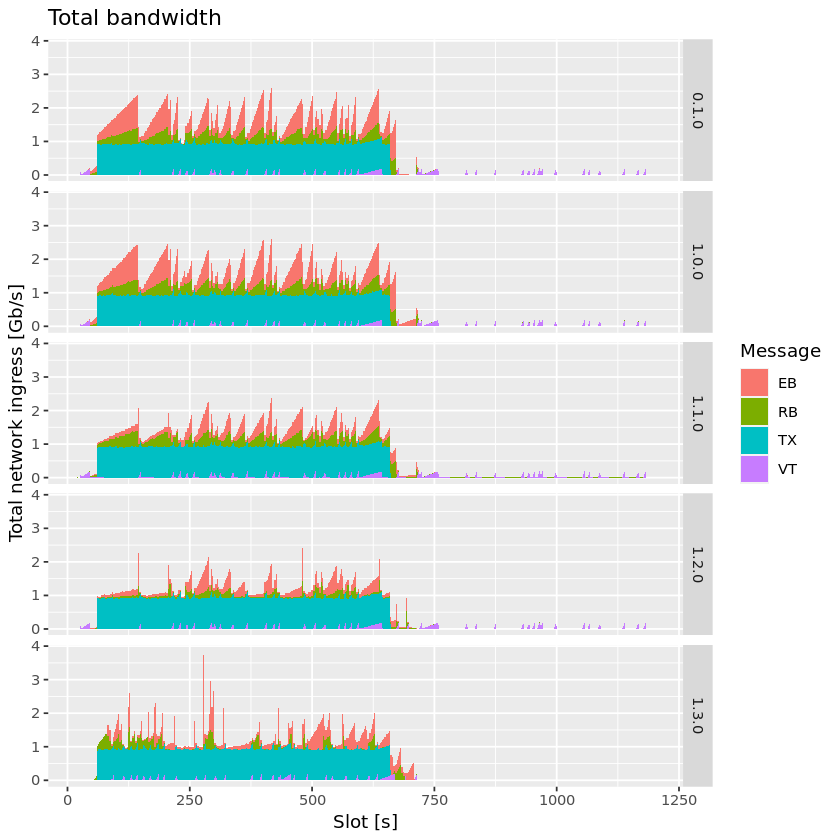

In [31]:
totalBandwidthPlot(
    receipts,
    "Total bandwidth",
    scales="fixed"
)

##### Bandwidth usage per node

In [32]:
nodeCount <- receipts[, length(unique(`Recipient`))]
nodeCount

[1] 750

In [33]:
meanNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
            rs[,
                .(`Size [Mb/node]`=8*sum(`Size [B]`)/1e6/nodeCount/sampleSize),
                by=.(`sim-cli`, `Slot`=floor(`Received [s]`), `Message`)
            ],
        aes(x=`Slot`, y=`Size [Mb/node]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`sim-cli` ~ ., scales=scales) +
        xlab("Slot [s]") +
        ylab("Mean network ingress among nodes [Mb/s]") +
        ggtitle(title)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

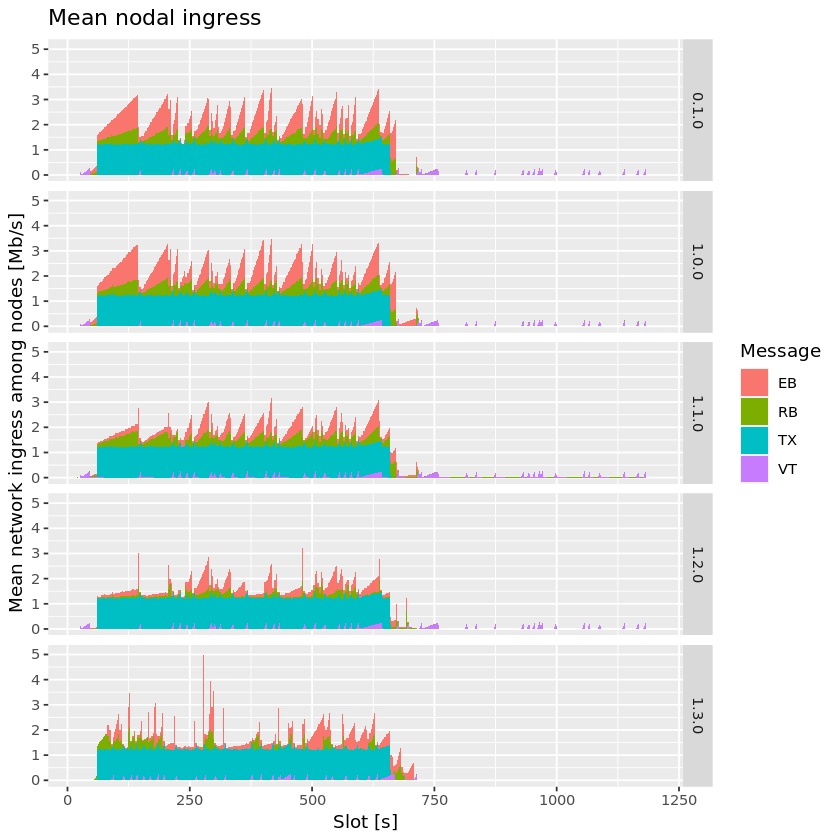

In [34]:
meanNodalIngressPlot(
    receipts, 
    "Mean nodal ingress",
    scales="fixed",
    outfiles=paste0("plots/ingress-average-area.svg")
)

In [35]:
peakNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
            rs[,
                .(`Size [Mb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e6/sampleSize),
                by=.(`sim-cli`, `Slot`=floor(`Received [s]`), `Message`, `Recipient`)
            ][,
                .(`Size [Mb]`=max(`Size [Mb]`)),
                by=.(`sim-cli`, `Slot`, `Message`)
            ],
        aes(x=`Slot`, y=`Size [Mb]`, color=`Message`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`sim-cli` ~ ., scales=scales) +
        xlab("Slot [s]") +
        ylab("Maximum network ingress among nodes [Mb/s]") +
        ggtitle(title)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

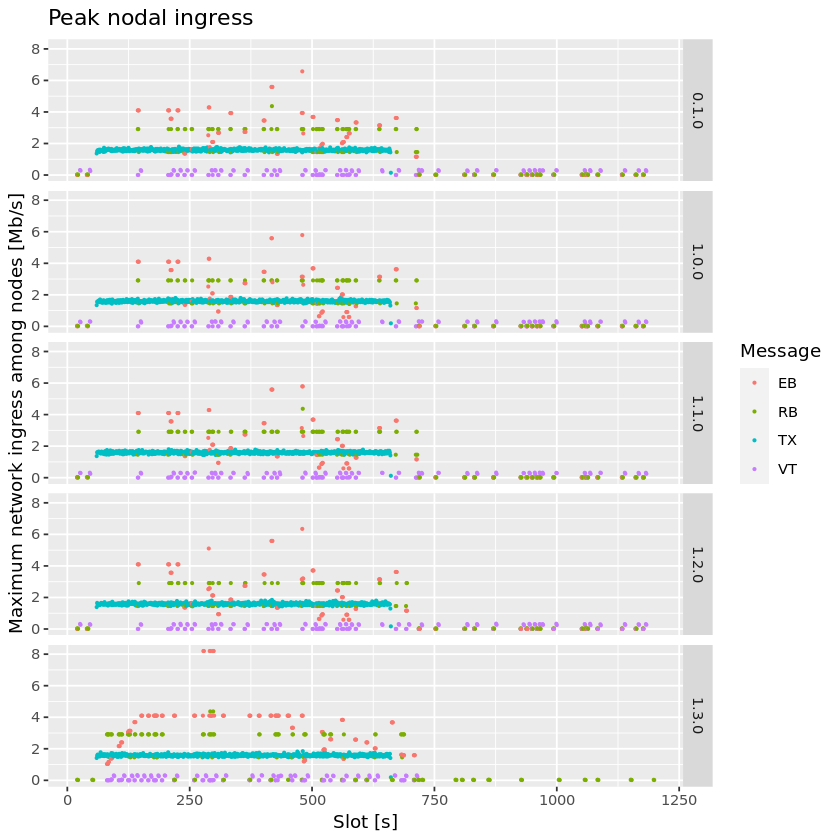

In [36]:
peakNodalIngressPlot(
    receipts, 
    "Peak nodal ingress"
)

### CPU usage

#### Read results

In [37]:
if (file.exists("results/cpus.Rdata")) {
    load(file="results/cpus.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    cpus <- fread("results/cpus.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
    save(cpus, file="results/cpus.Rdata")
    cat(paste("Saved Rdata file: sampleSize =", sampleSize, "\n"))
}
cpus %>% summary

Loaded Rdata file: sampleSize = 0.5 


  sim-cli          Tx start [s]  Tx stop [s]   Sim stop [s]       Slot       
 0.1.0:25738201   Min.   :60    Min.   :660   Min.   :1200   Min.   :  20.0  
 1.0.0:25739389   1st Qu.:60    1st Qu.:660   1st Qu.:1200   1st Qu.: 220.0  
 1.1.0:25740174   Median :60    Median :660   Median :1200   Median : 375.0  
 1.2.0:25734923   Mean   :60    Mean   :660   Mean   :1200   Mean   : 387.4  
 1.3.0:24826647   3rd Qu.:60    3rd Qu.:660   3rd Qu.:1200   3rd Qu.: 532.0  
                  Max.   :60    Max.   :660   Max.   :1200   Max.   :1199.0  
                                                                             
       Node                Task            Duration [s]      
 node-193:   171248   ValTX  :112353590   Min.   :0.0002800  
 node-163:   171223   ValVote: 14998099   1st Qu.:0.0006201  
 node-213:   171207   ValRB  :   117856   Median :0.0006201  
 node-138:   171196   ValRH  :   100927   Mean   :0.0009973  
 node-201:   171184   ValEB  :    94392   3rd Qu.:0.0006201  
 nod

In [38]:
cpusNode <-
        cpus[
            ,
            .(`Duration [s]`=sum(`Duration [s]`)),
            by=.(`sim-cli`, `Node`, `Slot`)
        ]

In [39]:
nodeCount <- cpusNode[, length(unique(`Node`))]
nodeCount

[1] 750

#### Peak CPU usage

##### Histogram

In [40]:
peakCpuHistogram <- function(cs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
            cs[,
                .(`Duration [%]`=100*max(`Duration [s]`)),
                by=.(`sim-cli`, `Slot`)
            ], 
        aes(x=`Duration [%]`)
    ) +
        geom_histogram(binwidth=10) +
        facet_grid(`sim-cli` ~ ., scales=scales) +
        xlab("Peak CPU load [%]") +
        ylab("Number of slots") +
        ggtitle(title)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

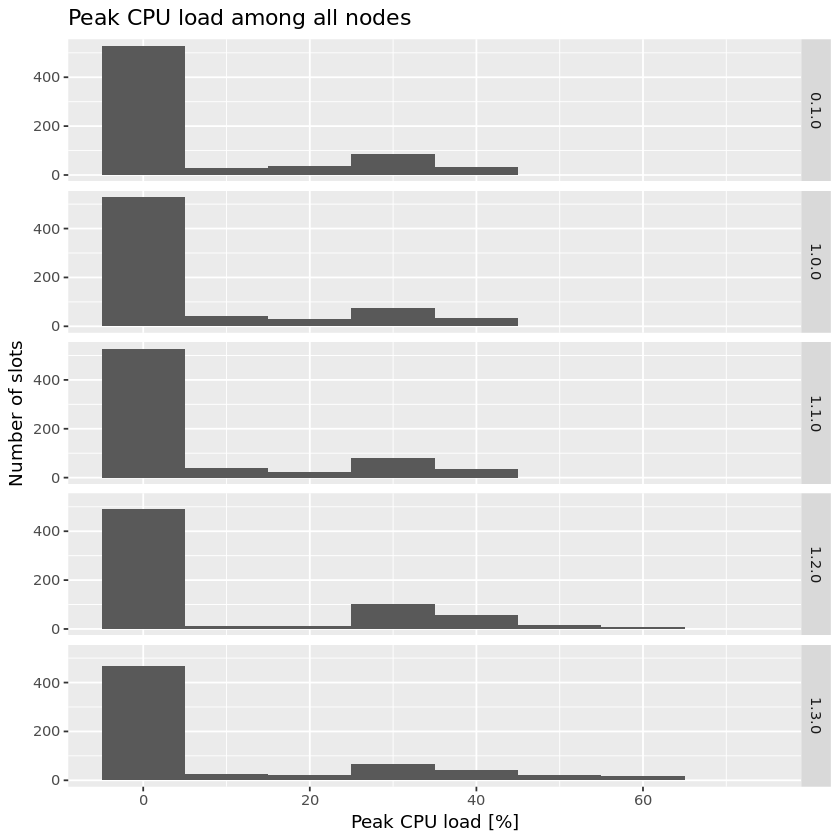

In [41]:
peakCpuHistogram(
    cpusNode, 
    "Peak CPU load among all nodes",
    scales="fixed"
)

##### Time series

In [42]:
peakCpuTimeseries <- function(cs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
            cs[,
                .(`Duration [%]`=100*mean(`Duration [s]`)/sampleSize),
                by=.(`sim-cli`, `Slot`)
            ], 
        aes(x=`Slot`, y=`Duration [%]`)) +
        geom_line() +
        facet_grid(`sim-cli` ~ ., scale=scales) +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

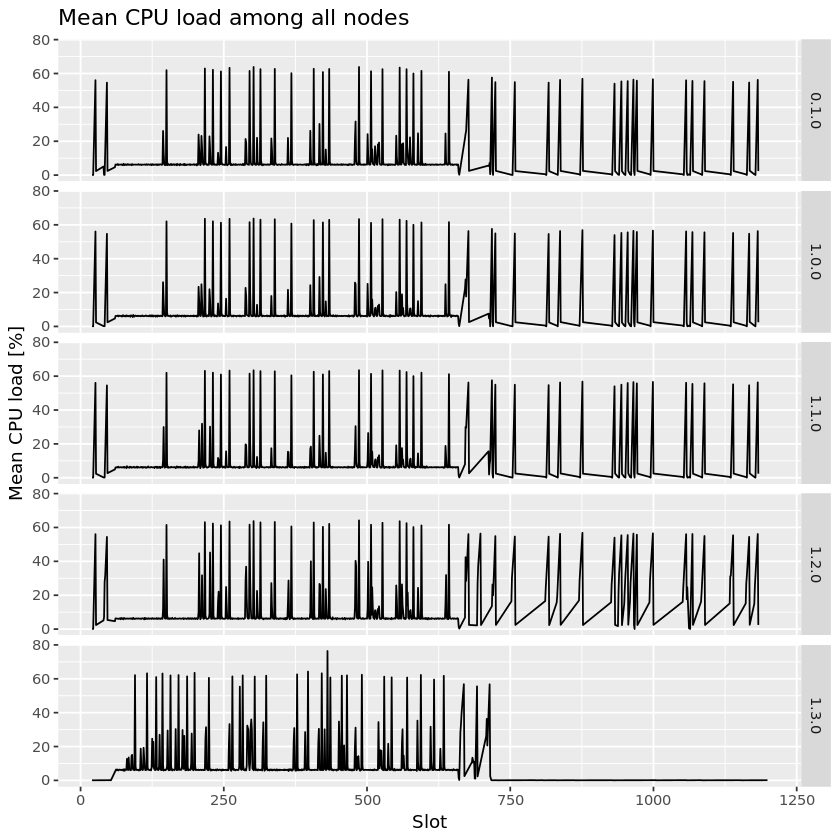

In [43]:
peakCpuTimeseries(
    cpusNode,
    "Mean CPU load among all nodes"
)

#### Mean CPU usage

##### Histogram

In [44]:
meanCpuHistogram <- function(cs, nodeSeconds, title="", scales="fixed", wide=FALSE, outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
            cs[,
                .(`Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds/nodeCount),
                by=.(`sim-cli`, `Task`)
            ], 
        aes(x="", fill=`Task`, y=`Duration [%]`)) +
        geom_bar(stat = "identity") +
        facet_grid(`sim-cli` ~ ., scales=scales) +
        xlab("") +
        ylab("Mean CPU load [%]") +
        ggtitle(title)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

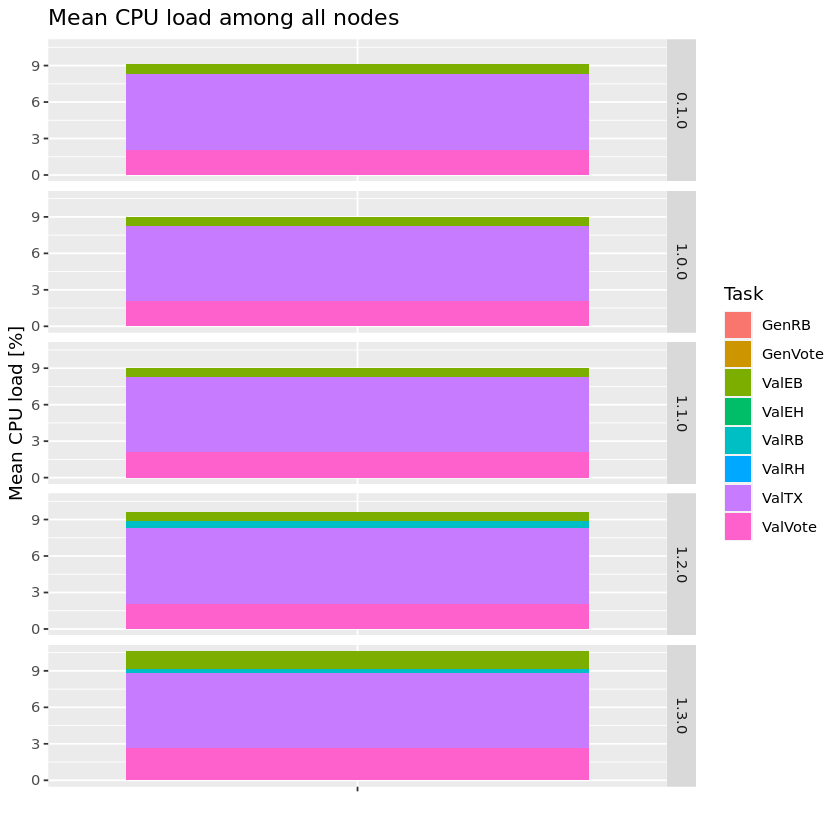

In [45]:
meanCpuHistogram(
    cpus[`Slot` >= txFirst & `Slot` < txLast],
    txWindow * sampleSize, 
    "Mean CPU load among all nodes", 
    scales="fixed"
)

##### Time series

In [46]:
meanCpuTimeseries <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
            cs[,
                .(`Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds/nodeCount/sampleSize),
                by=.(`sim-cli`, `Slot`, `Task`)
            ], 
        aes(x=`Slot`, y=`Duration [%]`, color=`Task`)
    ) +
        geom_point(size=0.25, alpha=0.75) +
        facet_grid(. ~ `sim-cli`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

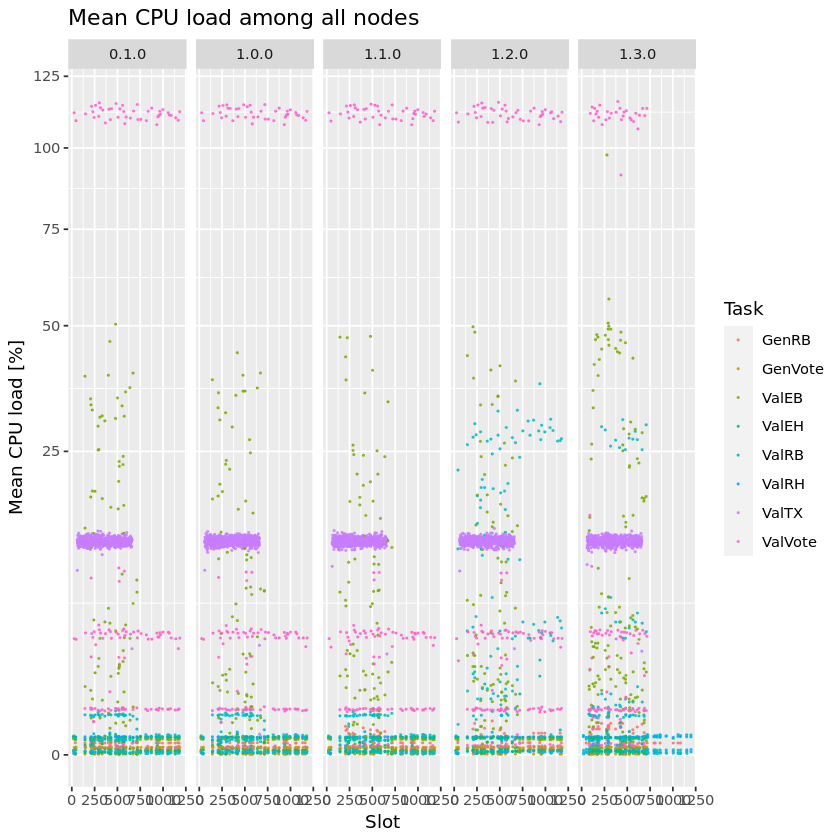

In [47]:
meanCpuTimeseries(
    cpus, 
    sampleSize, 
    "Mean CPU load among all nodes"
)

### Block contents

### Read data

In [48]:
if (file.exists("results/sizes.Rdata")) {
    load(file="results/sizes.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    sizes <- fread("results/sizes.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
    save(sizes, file="results/sizes.Rdata")
    cat(paste("Saved Rdata file: sampleSize =", sampleSize, "\n"))
}
setnames(sizes, old="Kind", new="Message")
sizes %>% summary

Loaded Rdata file: sampleSize = 1 


  sim-cli     Tx start [s]  Tx stop [s]   Sim stop [s]  Message 
 0.1.0:104   Min.   :60    Min.   :660   Min.   :1200   EB:255  
 1.0.0:104   1st Qu.:60    1st Qu.:660   1st Qu.:1200   RB:270  
 1.1.0:104   Median :60    Median :660   Median :1200           
 1.2.0:104   Mean   :60    Mean   :660   Mean   :1200           
 1.3.0:109   3rd Qu.:60    3rd Qu.:660   3rd Qu.:1200           
             Max.   :60    Max.   :660   Max.   :1200           
                                                                
            Item     Generated [s]      Transactions           Endorses  
 1083-node-568:  9   Min.   :  20.07   Min.   :   0   401-node-207 :  8  
 20-node-220  :  9   1st Qu.: 296.34   1st Qu.:   0   254-node-566 :  5  
 1051-node-135:  8   Median : 520.27   Median :  60   428-node-100 :  5  
 1058-node-94 :  8   Mean   : 564.35   Mean   :1678   1062-node-529:  4  
 1062-node-529:  8   3rd Qu.: 811.08   3rd Qu.:2835   1083-node-568:  4  
 1133-node-94 :  8   Max.   :1198.07

In [49]:
txSize <- 1500

### EB contents

#### Transactions

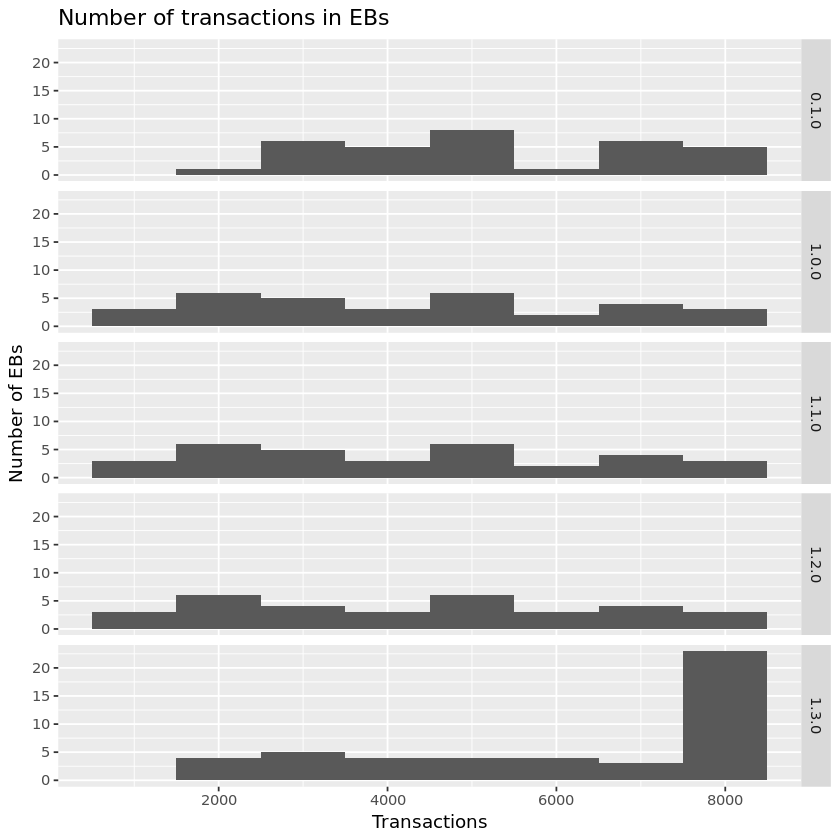

In [50]:
ggplot(sizes[`Message` == "EB" & `Transactions` > 0], aes(x=`Transactions`)) +
    geom_histogram(binwidth=1000) +
    facet_grid(`sim-cli` ~ .) +
    ylab("Number of EBs") +
    ggtitle("Number of transactions in EBs")

#### Sizes

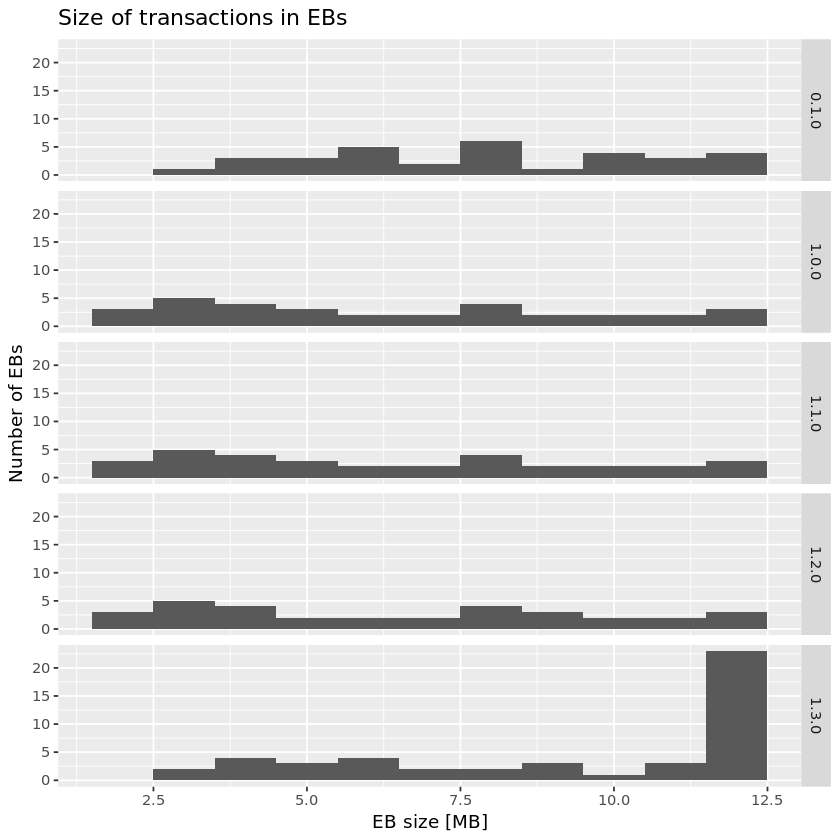

In [51]:
ggplot(
        sizes[`Message` == "EB" & `Transactions` > 0, .(`EB size [MB]`=`Transactions`*txSize/1e6), .(`sim-cli`)], 
    aes(x=`EB size [MB]`)
) +
    geom_histogram(binwidth=1) +
    facet_grid(`sim-cli` ~ .) +
    ylab("Number of EBs") +
    ggtitle("Size of transactions in EBs")

### RB contents

#### Transactions

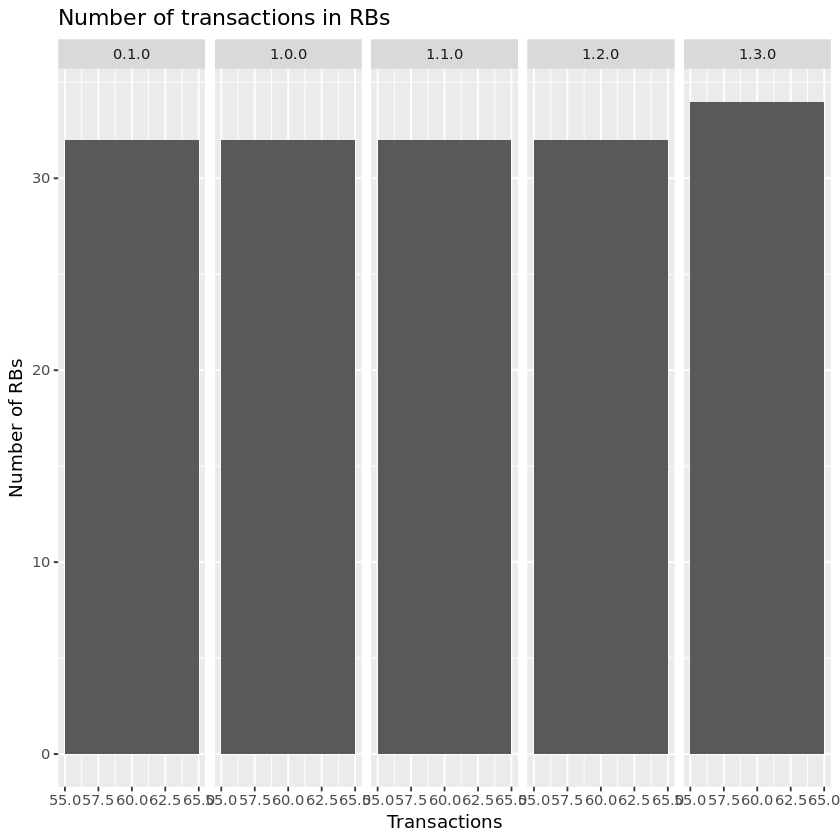

In [52]:
ggplot(sizes[`Message` == "RB" & `Transactions` > 0], aes(x=`Transactions`)) +
    geom_histogram(binwidth=10) +
    facet_grid(. ~ `sim-cli`) +
    ylab("Number of RBs") +
    ggtitle("Number of transactions in RBs")

#### Sizes

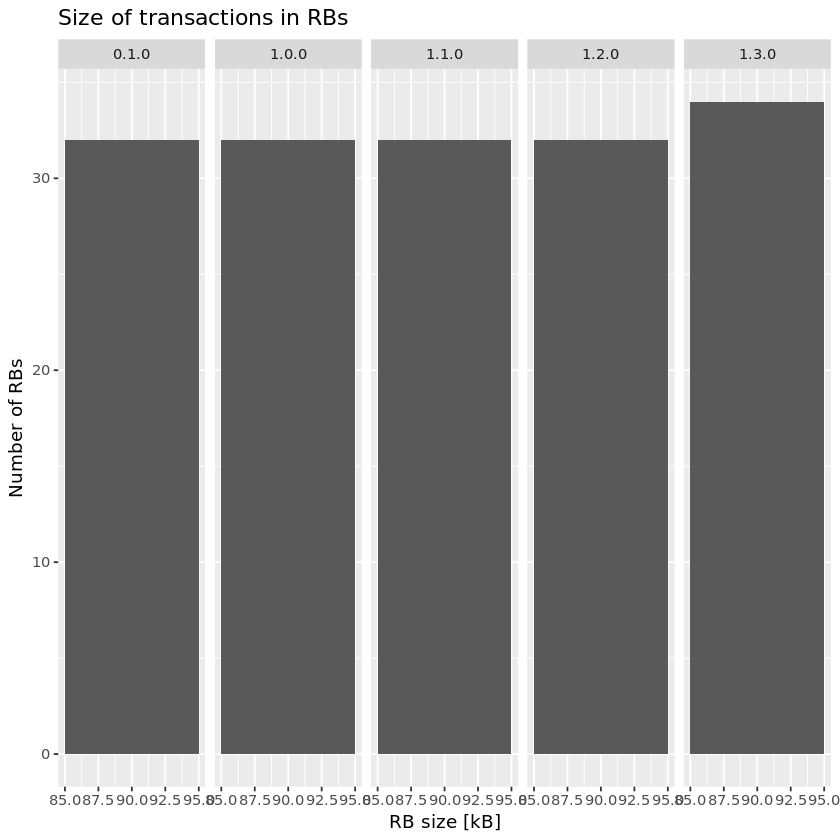

In [53]:
ggplot(
        sizes[`Message` == "RB" & `Transactions` > 0, .(`RB size [kB]`=`Transactions`*txSize/1e3), .(`sim-cli`)],
    aes(x=`RB size [kB]`)
) +
    geom_histogram(binwidth=10) +
    facet_grid(. ~ `sim-cli`) +
    ylab("Number of RBs") +
    ggtitle("Size of transactions in RBs")

### Disposition of blocks

#### Data processing

In [54]:
ebSizes <- 
        sizes[`Message` == "RB" & !is.na(`Endorses`), .(`Certified`=TRUE), .(`sim-cli`, `Item`=`Endorses`)][
        sizes[`Message` == "EB", .(`EB Transactions`=`Transactions`), .(`sim-cli`, `Item`)], 
            on=c("sim-cli", "Item")
        ][
            ,
            .(
                `EB txs later not certified`=ifelse(is.na(`Certified`), as.numeric(`EB Transactions`), 0),
                `EB txs later certified`=ifelse(is.na(`Certified`), 0, as.numeric(`EB Transactions`))
            ),
            .(`sim-cli`, `Item`)
        ]

In [55]:
rbSizes <- 
        ebSizes[
            ebSizes[, .(`EB txs certified now`=`EB txs later certified`), .(`sim-cli`, `Endorses`=`Item`)][
                sizes[`Message` == "RB", .(`Generated [s]`, `RB Transactions`=as.numeric(`Transactions`)), .(`sim-cli`, `Item`, `Endorses`)],
                on=c("sim-cli", "Endorses")
            ],
            on=c("sim-cli", "Item")
        ][
            ,
            .(
                `Generated [s]`,
                `RB`=`RB Transactions`,
                `EB later not certified`=`EB txs later not certified`,
                `EB later certified`=`EB txs later certified`,
                `EB now certified`=ifelse(is.na(`EB txs certified now`), 0, `EB txs certified now`)
            ),
            , .(`sim-cli`, `Item`)
        ]

In [56]:
blocks <- melt(
    rbSizes, 
    id.vars=c("sim-cli", "Item", "Generated [s]"),
    measure.vars=c("RB", "EB later not certified", "EB later certified", "EB now certified"),
    variable.name="Block",
    value.name="Transactions"
)

#### Transactions

Warning message:
“Removed 20 rows containing missing values (`position_stack()`).”


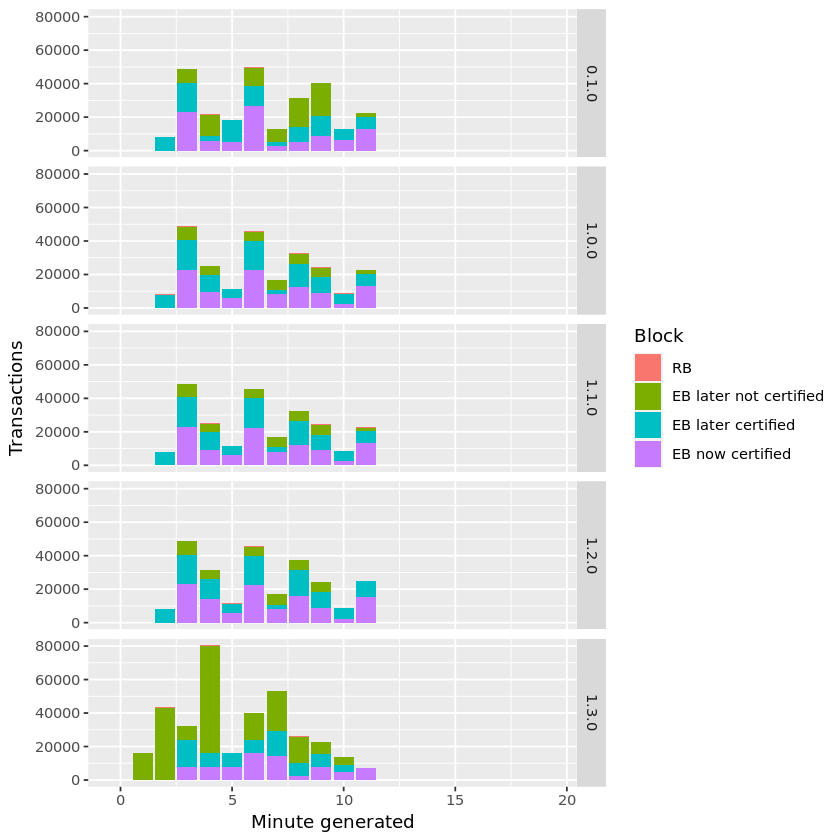

In [57]:
ggplot(
        blocks[, .(`Transactions`=sum(`Transactions`)), .(`sim-cli`, `Block`, `Minute generated`=(floor(`Generated [s]`/60)))],
    aes(x=`Minute generated`, y=`Transactions`, fill=`Block`)
) +
    geom_bar(stat="identity") +
    facet_grid(`sim-cli` ~ .)

Warning message:
“Removed 2 rows containing missing values (`position_stack()`).”


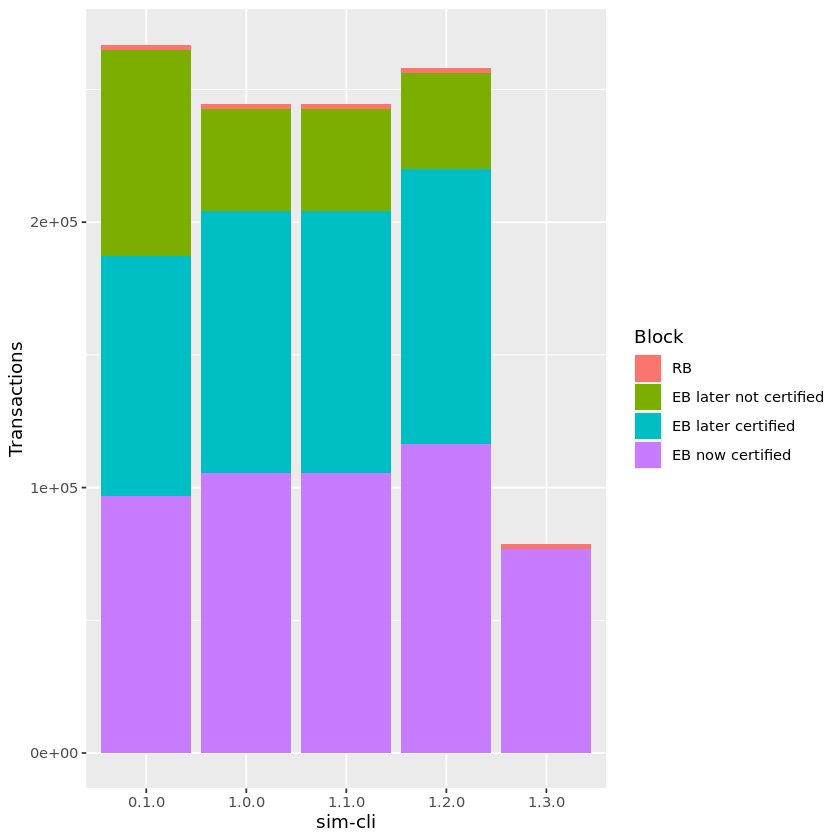

In [58]:
ggplot(
        blocks[, .(`Transactions`=sum(`Transactions`)), .(`sim-cli`, `Block`)],
    aes(x=`sim-cli`, y=`Transactions`, fill=`Block`)
) +
    geom_bar(stat="identity")

#### Sizes

Warning message:
“Removed 20 rows containing missing values (`position_stack()`).”


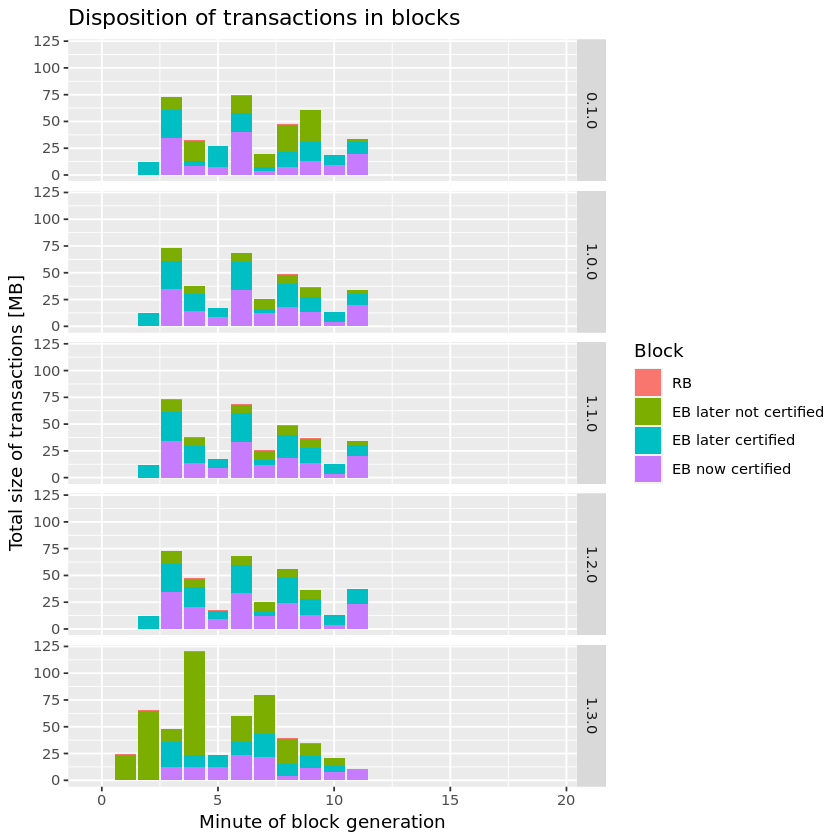

In [59]:
ggplot(
        blocks[, .(`Total size of transactions [MB]`=sum(`Transactions`)*txSize/1e6), .(`sim-cli`, `Block`, `Minute of block generation`=(floor(`Generated [s]`/60)))], 
    aes(x=`Minute of block generation`, y=`Total size of transactions [MB]`, fill=`Block`)
) +
    geom_bar(stat="identity") +
    facet_grid(`sim-cli` ~ .) +
    ggtitle("Disposition of transactions in blocks")

Warning message:
“Removed 2 rows containing missing values (`position_stack()`).”


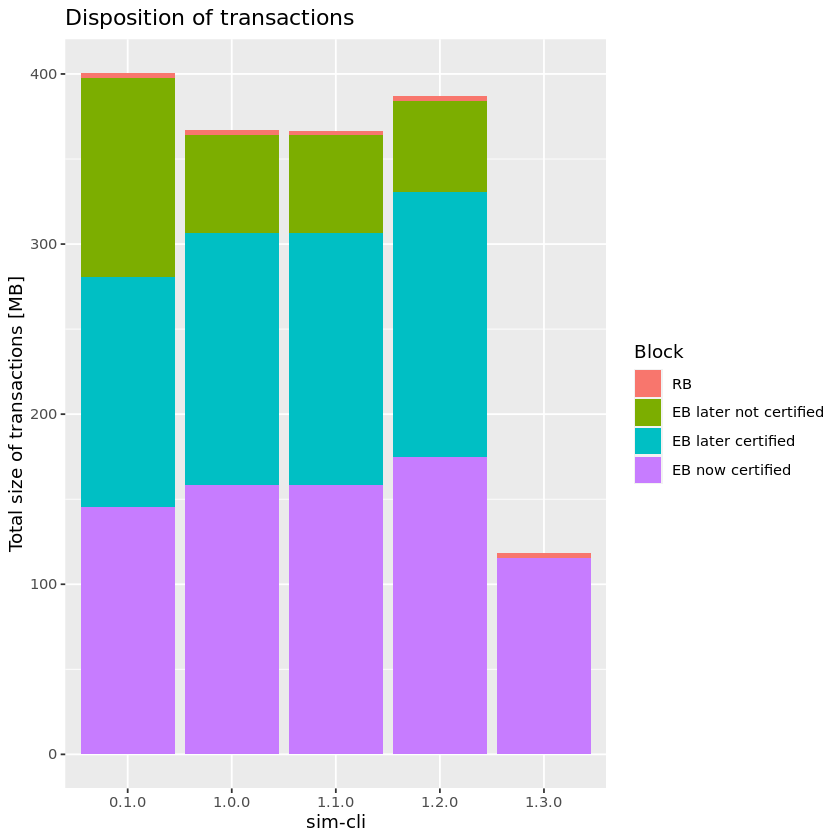

In [60]:
ggplot(
        blocks[, .(`Total size of transactions [MB]`=sum(`Transactions`)*txSize/1e6), .(`sim-cli`, `Block`)], 
    aes(x=`sim-cli`, y=`Total size of transactions [MB]`, fill=`Block`)
) +
    geom_bar(stat="identity") +
    ggtitle("Disposition of transactions")